# Generative Adversarial Networks (GAN)

Generative Adversarial Networks use two competing neural networks to create new output based on what it has learned from a training sample.

In the simplest setting (shown here), we have two networks, a ''generator'' and a ''discriminitor''.  The generator starts from random noise and tries to construct a realistic output, in our case, an image. The discriminator acts as a kind of judge to determin whether the output of the generator is realistic in the sense that it cannot be distinguished from the dataset used for training.

The modern approach of GANs was devloped by I. Goodfellow at al. in 2004 ([paper](https://arxiv.org/abs/1406.2661)), though it is argued that the underlying concepts have been developed by J. Schmidthuber starting in the early 1990s ([paper 1](https://arxiv.org/abs/1906.04493), [paper 2](http://people.idsia.ch/~juergen/FKI-126-90ocr.pdf), [paper 3](http://people.idsia.ch/~juergen/multipleways2009.pdf) and in particular [paper 4](https://ieeexplore.ieee.org/document/6795705)).

Since its original inception, many varieties of GANs have been developed, we will use DCGAN (deep convolutional GAN) by Radford et al ([paper](https://arxiv.org/abs/1511.06434)) here, using the model implementation from the [TensorFlow example](https://www.tensorflow.org/tutorials/generative/dcgan) by Google.

As the dataset, we will use the [MNIST](http://yann.lecun.com/exdb/mnist/) database by Y. LeCun which contains 60.000 images of hand-written digits.

In this setting, the output resembles such digits after about 50 training epochs. Trainining a single epoch even with this relatively simple setting can take up to some minutes depending on the underlying hardware.


In [1]:
##
## Import the libraries we need
##

# TensorFlow
import tensorflow as tf

# import import the layers from Keras in tensorflow to avoid typing
# a lot later when building the model
from tensorflow.keras import layers


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time


print(tf.__version__)


2.3.0


We now define some general settings.
 * The dataset contains 60.000 images, we will train the network using batches of 256 at a time
 * The generator starts off from random noise. In our case, we take 100 numbers taken from a standard Normal distribution and generate an image from these.

In [2]:
# general settings
batch_size = 256
noise_dim  = 100



## Load and Prepare Data

We now load the MNIST dataset. Since this is a very popular dataset, it is contained in many machine learning frameworks and can be accessed easily.
The dataset contains 60.000 images where each image is a gray scale image and has 28x28 pixels in x and y direction.
Each image is therefore characterized by the dimensions (28,28,1).

We first load the data and then show an example.

Once you have looked at this dataset, maybe try the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset developed by Zalando. This is intended as a ''drop-in replacement'' of the MNIST dataset and has the same dimensions and number of images - but it shows the outline of clothes instead.

11493376/11490434 [==============================] - 0s 0us/step
Number of images:   60000
x and y dimension:  28 28


Text(0.5, 1.0, 'Label: 5')

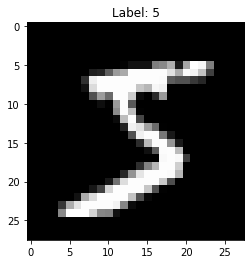

In [3]:
# MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

n_images = x_train.shape[0]
print('Number of images:  ', n_images)
print('x and y dimension: ', x_train.shape[1],x_train.shape[2])

plt.clf()
plt.imshow(x_train[0],cmap='gray',interpolation='none')
plt.title("Label: {}".format(y_train[0]))

Now we prepare the data from the dataset for the later training.

First we reshape the arrays holding the image data, in particular, we add the number ``1`` indicating the number of color channels, in our case, one gray scale.

Since the gray scale values range from 0...255, we first normalize the range to lie in the interval [-1,1]. When we want to draw an image later we have to remember to undo this step.

In [4]:
x_train = x_train.reshape(n_images, 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(n_images).batch(batch_size)

## Model definition

We now define the two models we need:
 * The generator takes random noise as input and creates a 28x28 pixel gray scale image from this. Hence our input shape we pass to the generator is (100,) and the output shape is (28,28,1). The generator uses [Conv2DTRanspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers that are the ''inverse'' of normal convolutional layers to create the image from the noise used as input.
 * The discriminator judges whether the images created by the generator are realistic. Hence we feed an tensor of shape (28,28,1) as input and our output is a single number, indicating whether the image is realistic or not. Note that in this case the model uses convolutional layers with a stride of 2 instead of maxpooling.

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

We now create an instance of the generator model. Since this is a fully defined model, we can use it to generate an image. However, since the generator has not yet been trained, we expect just random noise.

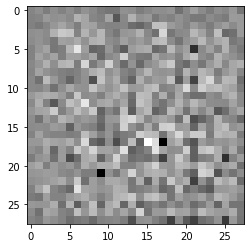

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

Now we create an instance of the discriminator model. Like the generator instance, this is already a fully working model - so we can feed it the above image and as expected, it is not deemed as a realistic image.

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision.numpy())

[[-0.00117752]]


Next, we define the loss functions the models will use.
The discriminator should learn that real images (```real_output```) are correct and have a target value of 1, the fake images should be rejected and have a target value of 0. Hence, intuitively, the generator aims to ''beat'' the discriminator by creating images the discriminator cannot tell apart from the real images, which is reflected in the loss function of the generator.

We also define the optimizer with a small learning rate for both models.

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define Training Loop

We now define the relevant parts used to actually train the network.
First, we define the main training loop 
```
def train(dataset, epochs=50, rows=2, columns=2)
```
This loop runs for the number of epochs we will specify (50 by default) and takes the training dataset as further input.
During training we will show a few examples arranged in rows and columns (2 as default) of what the generator can produce at this stage since each training epoch will take somewhere between a few seconds and some minutes. To make this easier to compare, we always start from the same noise, hence we generate this seed first. 

The actual training then happes in the function ```train_step```.
Note that we use there the decorator [```tf.function```](https://www.tensorflow.org/api_docs/python/tf/function) to improve the performance.
Inside each training step, we first generate the noise the generator starts from and then let the generator create some images according to the current batch size.
The discriminator then computes the output of the real images from the training dataset as well as the corresponding output from the faked images and we compute the values of the loss - functions. Note that we use [```GradientTape```](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to define the training loop ourselves - refer to the corresponding example in our repository if you're not yet familiar with them.

We also define a small helper function to plot an array of images.

In [9]:
def train(dataset, epochs=50, rows=2, columns=2):

  #always start from the same noise
  seed = tf.random.normal([rows*columns, noise_dim])

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    plot_images(rows, columns, seed, generator)


    print ('Epoch number {} took {} sec to train '.format(epoch , time.time()-start))



In [10]:

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
def plot_images(n_row, n_column, input, model):
  gen_imgs = model(input, training=False)
  fig = plt.figure(figsize=(n_row,n_column))

  for i in range(n_row*n_column):
    plt.subplot(n_row, n_column, i+1)
    plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.show()

## Train the network

We now train the network using the above functions and save the models afterwards.

50 epochs should be sufficient so that the output resembles hand-written digits. They won't be perfect but it's clear enough to see that it works

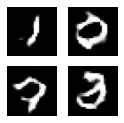

Epoch number 49 took 23.667637825012207 sec to train 
Training completed - save models
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: generator/assets
INFO:tensorflow:Assets written to: discriminator/assets
discriminator  generator  sample_data


In [12]:
# few images during each training epoch
train(train_dataset, epochs=50, rows=2, columns=2)

print('Training completed - save models')
generator.save('generator')
discriminator.save('discriminator')
!ls

## Final output
After the training is completed we generate a few examples

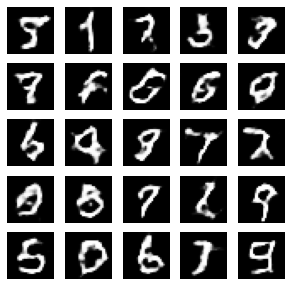

In [13]:
# larger number of image at the end

n_row = 5
n_column = 5
input_noise = tf.random.normal([n_row*n_column, noise_dim])

plot_images(n_row, n_column, input_noise, generator)
